# Map of trend SODA data

In [2]:
import xarray as xr
import xesmf as xe
import numpy as np

import regionmask

import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
# Import soda reanalysis data

path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/raw'
soda = xr.open_mfdataset(f'{path}/*.nc')

In [4]:
soda

,Array,Chunk
Bytes,21.77 GiB,543.82 MiB
Shape,"(492, 50, 330, 720)","(12, 50, 330, 720)"
Count,83 Graph Layers,41 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,21.77 GiB,543.82 MiB
Shape,"(492, 50, 330, 720)","(12, 50, 330, 720)"
Count,83 Graph Layers,41 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [15]:
# Obtain annual averages
soda = soda.groupby('time.year').mean().rename({'year':'time'})

# Remove weighted global average SSH

weights = np.cos(np.deg2rad(soda.yt_ocean))
soda_weighted = soda.weighted(weights)

soda_global = soda_weighted.mean(['xt_ocean', 'yt_ocean'])

soda['ssh'] = soda['ssh'] - soda_global.ssh


# Change longitude values from [0, 360] to [-180, 180]
xt_newvalues = list(np.arange(0.25, 180, 0.5)) + list(np.arange(-179.75, 0, 0.5))

soda['xt_ocean'] = xt_newvalues

soda = soda.sortby(['xt_ocean'])


# Drop unnecessary variables
soda = soda.drop(['wt', 'mlt', 'mlp', 'mls', 'temp', 'salt', 'net_heating', 'prho', 'taux', 'tauy', 'sw_ocean', 'u', 'v', 'xu_ocean', 'yu_ocean', 'st_ocean'])

# Rename coordinates
soda = soda.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})


# Select smaller area
soda = soda.where((soda.longitude > -20) & (soda.longitude < 10) & (soda.latitude > 36) & (soda.latitude < 62), drop = True)

# Rename variables
soda = soda

# Convert from m to mm
soda['ssh'] = soda.ssh*1000

In [16]:
# Define polygon region

NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])

NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

In [17]:
# Calculate rates
coef = soda.ssh.polyfit(dim='time', deg=1, full=False)
rate = (coef).polyfit_coefficients.sel(degree=1)

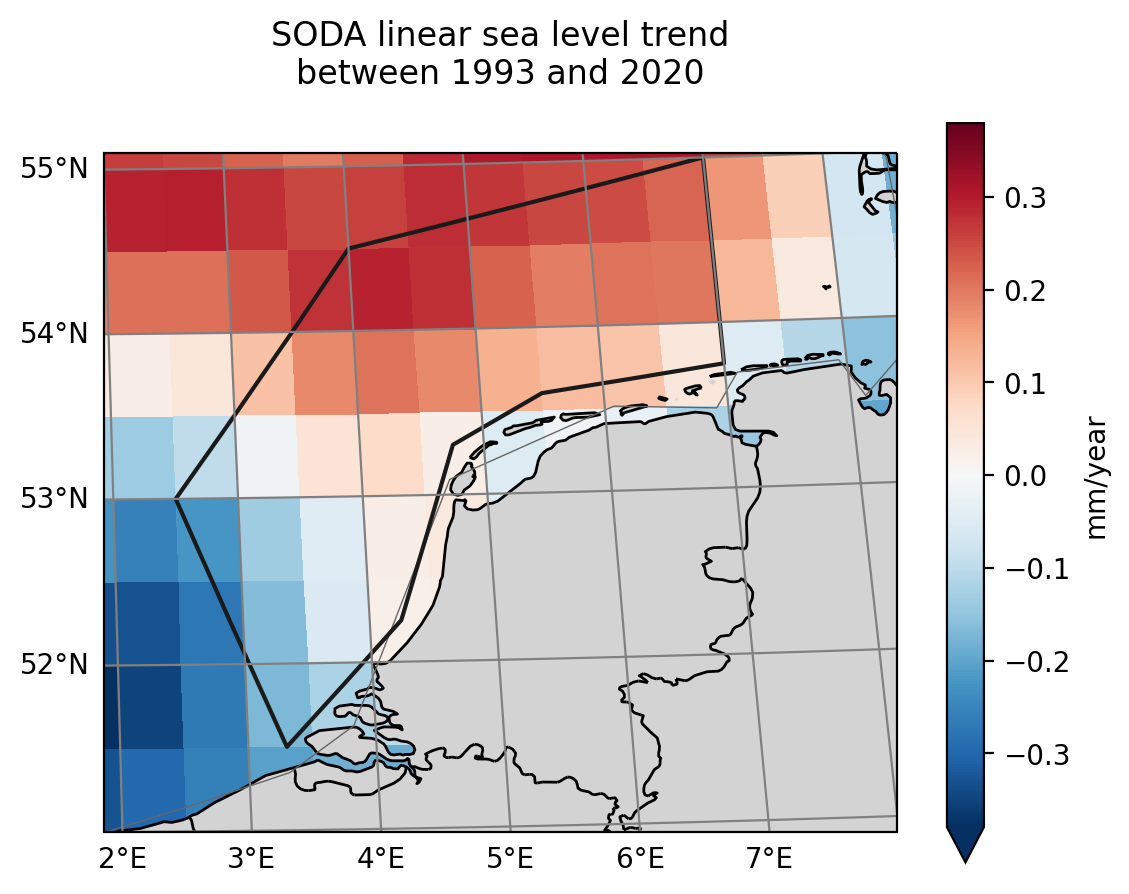

In [18]:
# Plot polygon region and rates

lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = rate.sel(longitude=slice(lon_min-1,lon_max+1), 
             latitude=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('SODA linear sea level trend\nbetween 1993 and 2020', pad=25)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/SODA/linear trend/SODA_Dutch_coast')

## First regrid to AVISO grid

In [19]:
# Import AVISO data to regrid
aviso = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/l4_duacs_0.25deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1659969934244.nc')

# Drop unnecessary variables
aviso = aviso.drop(['crs'])

In [20]:
def regrid(input_data, roms_data, sl_var):
    '''
    Function to regrid datasets onto the AVISO 1/4° grid. 
    input_data should be the data that needs to be regridded
    aviso_data should be the data whereon the input_data will be regridded
    sl_var should be the name for sea level variable in the input_data 
    '''
    
    # Sort coordinates in increasing order
    input_data = input_data.sortby(['latitude', 'longitude'])
    
    # Transpose dimensions
    input_data = input_data.transpose('time', 'latitude', 'longitude')
    
    # Make arrays C_CONTIGUOUS
    roms_data = roms_data.astype(dtype = 'float32', order = 'C')
    input_data[sl_var] = input_data[sl_var].astype(dtype = 'float32', order = 'C')
    
    # Add mask
    input_data['mask'] = xr.where(~np.isnan(input_data[sl_var].isel(time=0)), 1, 0)
    roms_data['mask'] = xr.where(~np.isnan(roms_data.adt.isel(time=0)), 1, 0)
    
    # Build regridder
    regridder = xe.Regridder(input_data, roms_data, "bilinear", extrap_method= 'nearest_s2d')
    
    # Apply to data
    regridded_data = regridder(input_data)
    
    # Drop mask
    regridded_data = regridded_data.drop(['mask'])
    
    return regridded_data

In [21]:
soda = regrid(soda, aviso, 'ssh')

In [22]:
# Calculate rates
coef = soda.ssh.polyfit(dim='time', deg=1, full=False)
rate = (coef).polyfit_coefficients.sel(degree=1)

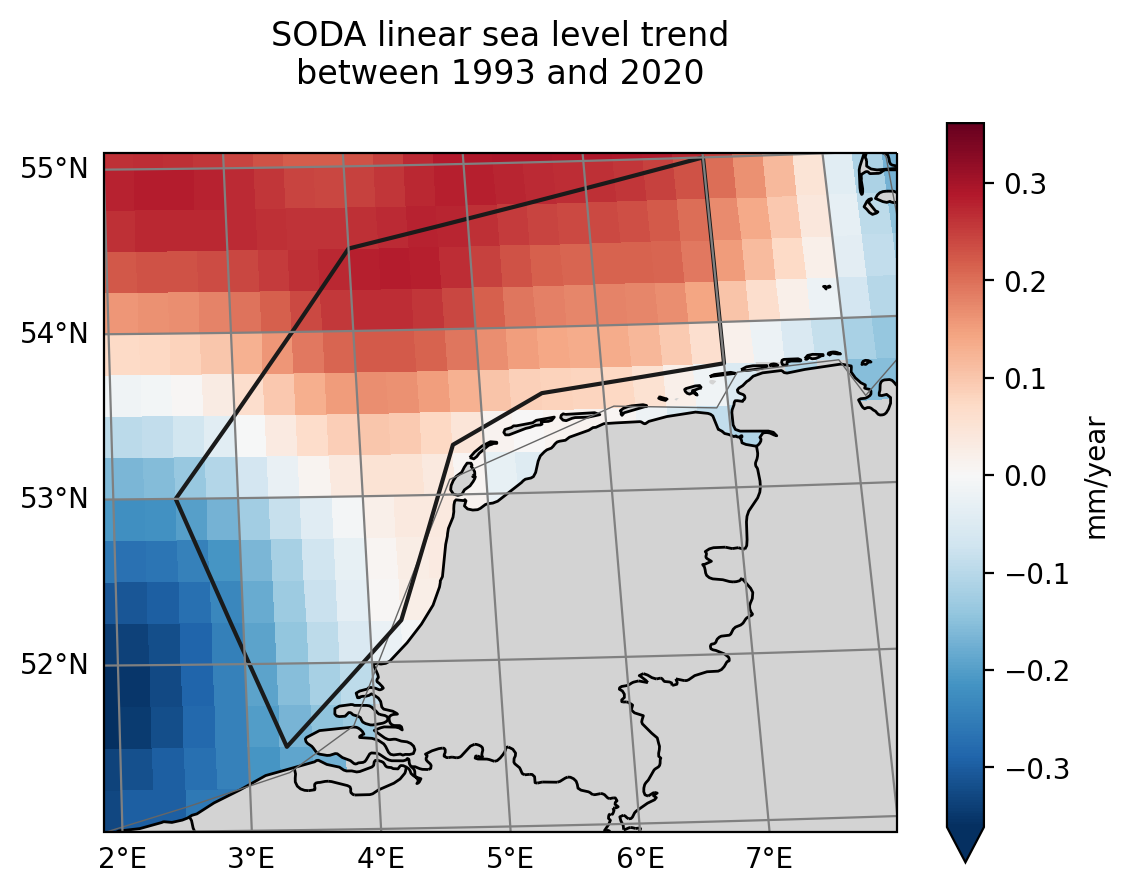

In [23]:
# Plot polygon region and rates

lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = rate.sel(longitude=slice(lon_min-1,lon_max+1), 
             latitude=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('SODA linear sea level trend\nbetween 1993 and 2020', pad=25)


plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/SODA/linear trend/SODA_Dutch_coast_regridded')

# Obtain trends for the SODA data

Obtain linear trends over the period 1993-2020 for SODA ocean dynamic sea level averaged over the polygon area and tide gauge stations for both soda data corrected and not corrected for global mean ssh.





In [128]:
import xarray as xr
import pandas as pd
import numpy as np

import regionmask

from scipy.stats import linregress
import matplotlib.pyplot as plt

In [129]:
soda_corrected = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/SODA/processed/soda.nc')
soda_notcor = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/SODA/processed/soda_noglobalcor.nc')


### Some data preparation

In [130]:
# Obtain annual averages
soda_corrected = soda_corrected.groupby('time.year').mean().rename({'year':'time'})
soda_notcor = soda_notcor.groupby('time.year').mean().rename({'year':'time'})

# Drop some coordinates
soda_corrected = soda_corrected.drop(['thetao', 'so', 'uo', 'vo', 'depth', 'xu_ocean', 'yu_ocean'])
soda_notcor = soda_notcor.drop(['thetao', 'so', 'uo', 'vo', 'depth', 'xu_ocean', 'yu_ocean'])


# Select data from 1993 to 2020
soda_corrected = soda_corrected.where(soda_corrected.time > 1992, drop = True)
soda_notcor = soda_notcor.where(soda_notcor.time > 1992, drop = True)

# Rename coordinates
soda_corrected = soda_corrected.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})
soda_notcor = soda_notcor.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})


# Convert from m to mm
soda_corrected['zos'] = soda_corrected.zos*1000
soda_notcor['zos'] = soda_notcor.zos*1000

## Obtain average over polygon area

In [131]:
def obtain_polygon_region_data(data, var):
    '''
    Function to obtain a new dataset containing the data averaged over polygon areas
    
    
    '''
    
    
    df = pd.DataFrame(index=pd.Series(data.time.values, name="time"))
    
    
    location = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
    
    region = regionmask.Regions([location], names=['reg'], abbrevs=['reg'])
    
    # Define the mask and change its value from 0 to 1
    mask_alti = region.mask_3D(data.longitude, data.latitude)
    
    data_m = data.where(mask_alti)
    
    
    # Calculate the weighted regional average
    # !!! Only works with regular grids
    weights = np.cos(np.deg2rad(data.latitude))
    region_average = data.weighted(mask_alti * weights).mean(dim=('latitude', 'longitude'))
    
    if len(var) == 1:
        var, = var
        df['Average'] = region_average[var] - region_average[var][0]
    else:
        for v in var:
            df[f'Average {v}'] = region_average[v] - region_average[v][0]
    
    return df 

In [132]:
# Select polygon data
soda_corrected_poly = obtain_polygon_region_data(soda_corrected, ['zos'])
soda_notcor_poly = obtain_polygon_region_data(soda_notcor, ['zos'])

## Obtain linear trends

In [133]:
soda_corrected_poly_trend = np.polyfit(soda_corrected_poly.index.values, soda_corrected_poly.Average.values, 1)[0]
soda_notcor_poly_trend = np.polyfit(soda_notcor_poly.index.values, soda_notcor_poly.Average.values, 1)[0]


slope, intercept, r_value, p_value, std_err = linregress(soda_corrected_poly.index.values, soda_corrected_poly.Average.values)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(soda_notcor_poly.index.values, soda_notcor_poly.Average.values)

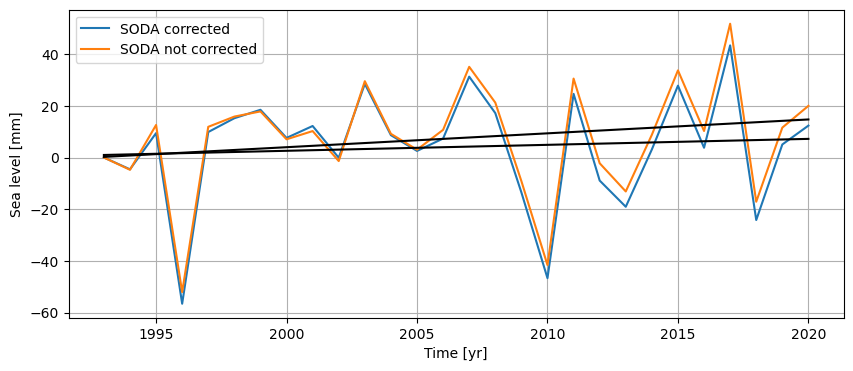

In [134]:
plt.figure(figsize=(10, 4))
plt.plot(soda_corrected_poly.index.values, soda_corrected_poly.Average.values, label='SODA corrected')
plt.plot(soda_notcor_poly.index.values, soda_notcor_poly.Average.values, label='SODA not corrected')
plt.legend()
plt.plot(soda_corrected_poly.index.values, intercept + slope*soda_corrected_poly.index.values, 'k', label='fitted line')
plt.plot(soda_notcor_poly.index.values, intercept1 + slope1*soda_notcor_poly.index.values, 'k', label='fitted line')

plt.xlabel('Time [yr]')
plt.ylabel('Sea level [mm]')
plt.grid()

In [135]:
soda_corrected_poly_trend 

0.2306423737298885

In [136]:
soda_notcor_poly_trend 

0.5365670114949226

## Obtain SODA data for tide gauge stations

In [137]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']


def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['name'] = stations[:-1]
    df = df.set_index('name')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df


coord_df = station_coords()


def obtain_near_tg_data(data):
    '''
    Function to obtain a new dataframe containing the data near tide gauge stations
    
    '''
    
    df = pd.DataFrame({'time' : data.time.data}).set_index('time')
    
    for station in coord_df.index:
        
        # Select data near tide gauge
        if station in ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Harlingen']:
            data_stat = data.sel(longitude = coord_df['lon'][station]-0.3, latitude = coord_df['lat'][station], method = 'Nearest').zos.data
            
        elif station == 'Delfzijl':
            data_stat = data.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station]+0.3, method = 'Nearest').zos.data
            
        else:
            data_stat = data.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], method = 'Nearest').zos.data
    
            
        # Obtain anomaly
        data_stat_anom = data_stat - data_stat[0] 
    
    
        # Save in dataframe
        df[station] = data_stat_anom
        
        
    df['Average'] = df.mean(axis=1)
    
    return df

In [138]:
# Select data near tide gauges
soda_corrected_tg = obtain_near_tg_data(soda_corrected)
soda_notcor_tg = obtain_near_tg_data(soda_notcor)

## Obtain linear trends

In [139]:
soda_corrected_tg_trend = np.polyfit(soda_corrected_tg.index.values, soda_corrected_tg.Average.values, 1)[0]
soda_notcor_tg_trend = np.polyfit(soda_notcor_tg.index.values, soda_notcor_tg.Average.values, 1)[0]

slope, intercept, r_value, p_value, std_err = linregress(soda_corrected_tg.index.values, soda_corrected_tg.Average.values)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(soda_notcor_tg.index.values, soda_notcor_tg.Average.values)

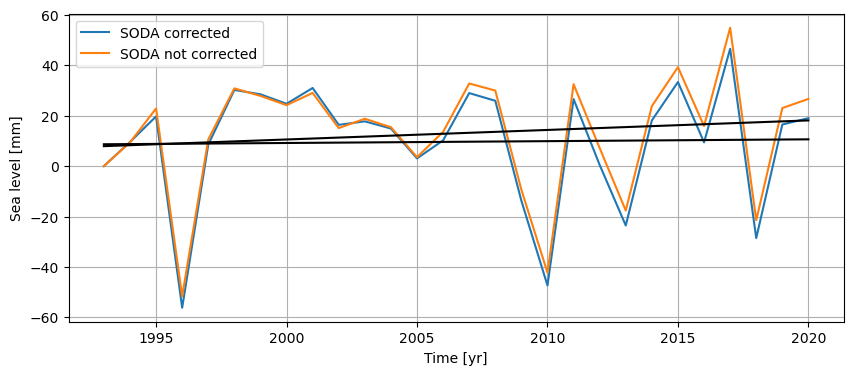

In [140]:
plt.figure(figsize=(10, 4))
plt.plot(soda_corrected_tg.index.values, soda_corrected_tg.Average.values, label='SODA corrected')
plt.plot(soda_notcor_tg.index.values, soda_notcor_tg.Average.values, label='SODA not corrected')
plt.legend()
plt.plot(soda_corrected_tg.index.values, intercept + slope*soda_corrected_tg.index.values, 'k', label='fitted line')
plt.plot(soda_notcor_tg.index.values, intercept1 + slope1*soda_notcor_tg.index.values, 'k', label='fitted line')

plt.xlabel('Time [yr]')
plt.ylabel('Sea level [mm]')
plt.grid()

In [141]:
soda_corrected_tg_trend 

0.07248244664912662

In [142]:
soda_notcor_tg_trend 

0.378407342550084